**Problem statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

##1. Data Reading/Data Understanding
Importing Skin Cancer Data

#### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [2]:
from google.colab import drive
drive.mount('/content/drive')
udayrantta

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types.<br>
The dataset contains 9 sub-directories in each train and test subdirectories.<br>
The 9 sub-directories contains the images of 9 skin cancer types.

**Defining the path for train and test images**<br>
We will Update the paths of the train and test dataset

In [3]:
data_dir_train = pathlib.Path("drive/My Drive/Colab Notebooks/CNN_assignment/Train/")
data_dir_test = pathlib.Path('drive/My Drive/Colab Notebooks/CNN_assignment/Test/')

Count the Total number of images in Train and Test files

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## 2. Dataset Creation

Define some parameters for the loader:<br>
We will start with batch size 32 and resize the images to 180*180

In [5]:
batch_size = 32
img_height = 180
img_width = 180

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.<br>
We will use a seed of 123 and resize the images to 180*180.<br>
Let's use 80% of the images for training, and 20% for validation.

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Similarly, we will create the validation dataset from 20% of the images

In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


Listing the classes of cancer using class_names from train dataset.

In [8]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


##3. Dataset visualisation
We will create a code to visualize one instance of all the nine classes present in the dataset

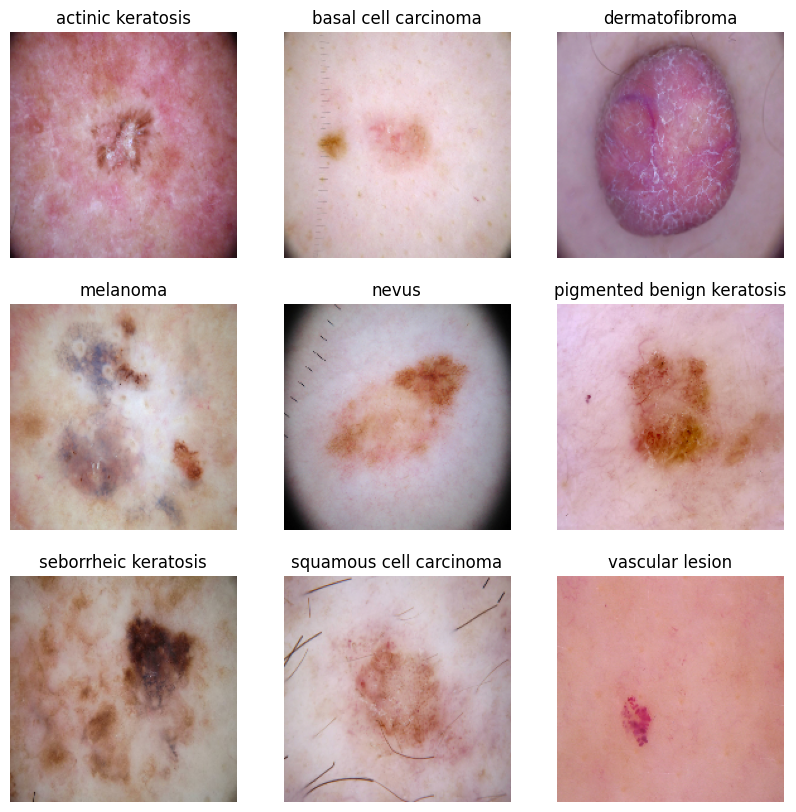

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image_batch, label_batch in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[0].numpy().astype('uint8'))
        plt.title(class_names[label_batch.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB).<br>
The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [10]:
print(image_batch.shape)
print(label_batch.shape)

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##4. Model Building & training
We will create a CNN model, which can accurately detect 9 classes present in the dataset.<br>
Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

Creating the model

In [12]:
num_classes = len(class_names)
# model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

#### Compile the model
We will use `categorical_crossentropy` as our loss function and `sgd` as a optimizer

In [13]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 88, 88, 64)        0         
                                                                 
 flatten (Flatten)           (None, 495616)            0         
                                                        

**Explaining the Output shape and Param #**

**1.** `conv2d (Conv2D)             (None, 178, 178, 32)      896`<br>
from (180,180,3) input, we appy 3 x3, 32 filters<br>
so output will be ((180+2*0-3)/1) +1 , stride =1, padding=0 = 178. So (178,178,32)<br>
Parameters will be (3 *3 *3 * 32) + 32 =896


**2** `conv2d_1 (Conv2D)           (None, 176, 176, 64)      18496`<br>
from (178,178,32) input, we appy 3 x3, 64 filters<br>
so output will be ((178+2*0-3)/1) +1 , stride =1, padding=0 = 176. So (176,176,64)<br>
Parameters will be ((3 *3 * 32) + 1)*64 =18496

**3** `max_pooling2d (MaxPooling2D)  (None, 88, 88, 64)       0 `<br>
from (176,176,64) input, we do maxpooling with 2 * 2 pool size<br>
so output will be 176/2 = 88 (88,88,64)<br>


**4** `dropout (Dropout)           (None, 88, 88, 64)        0 `<br>
from (88,88,64) input, dropout of 25% connections<br>

**5** `flatten (Flatten)           (None, 495616)            0 `<br>
from (88,88,64) input, we flatten the tensor
so output will be 88 * 88 * 64 =495616 <br>

**6** `dense (Dense)               (None, 128)               63438976`<br>
from (495616) input, we perform Dense NN
so parameters will be 495616* 128 + 128  =63438976 <br>

**7** `dropout_1 (Dropout)         (None, 128)               0`<br>
from input, doprout of 50% connections<br>

**8** `dense_1 (Dense)             (None, 9)                 1161`<br>
from (128) input, we perform Dense NN
so parameters will be 128*9 +9 =1161 <br>





#### Train the model
We will use 20 epochs

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 144s 2s/step - loss: 2.0941 - accuracy: 0.1959 - val_loss: 2.0271 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 6s 107ms/step - loss: 2.0425 - accuracy: 0.2383 - val_loss: 1.9712 - val_accuracy: 0.3266
Epoch 3/20
56/56 [==============================] - 6s 106ms/step - loss: 1.9975 - accuracy: 0.2550 - val_loss: 1.9319 - val_accuracy: 0.3177
Epoch 4/20
56/56 [==============================] - 6s 108ms/step - loss: 1.9483 - accuracy: 0.2589 - val_loss: 1.8670 - val_accuracy: 0.3087
Epoch 5/20
56/56 [==============================] - 6s 105ms/step - loss: 1.9307 - accuracy: 0.2863 - val_loss: 1.9205 - val_accuracy: 0.2953
Epoch 6/20
56/56 [==============================] - 6s 106ms/step - loss: 1.8719 - accuracy: 0.3092 - val_loss: 1.7126 - val_accuracy: 0.3915
Epoch 7/20
56/56 [==============================] - 6s 105ms/step - loss: 1.8725 - accuracy: 0.3164 - val_loss: 1.7546 - val_accuracy: 0.3781
Epoch 8

**Visualizing training results**

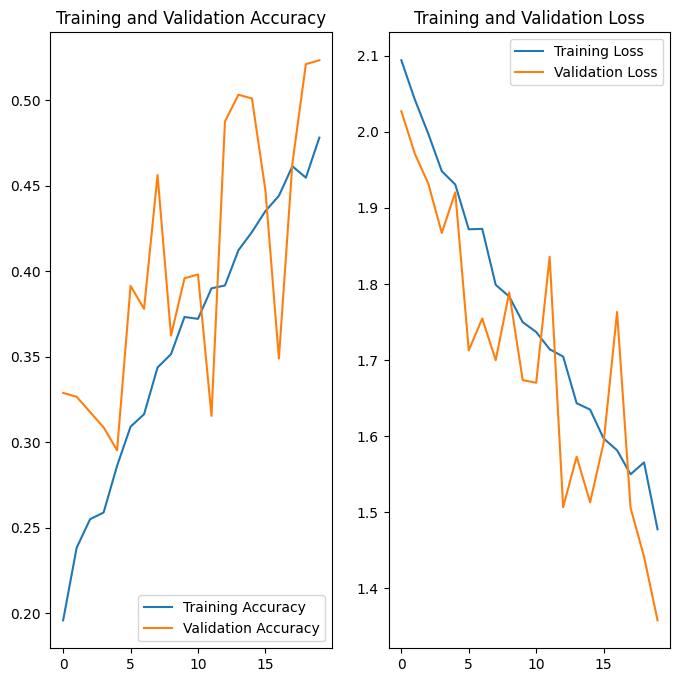

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training and validation accuracy is low.<br>
Accuracy and validation accuracy are around 0.50 which is less (*not mentioning exact number as it changes on rerun*). Its a case of underfitting as our Accuracy itself is very low.

The loss is also not too low. So the model will need to be fixed to achieve more accuracy.

Let's try usin **other optimizer, `adam`**

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 88, 88, 64)        0         
                                                                 
 flatten (Flatten)           (None, 495616)            0         
                                                        

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 100ms/step - loss: 1.9935 - accuracy: 0.4062 - val_loss: 1.6488 - val_accuracy: 0.4765
Epoch 2/20
56/56 [==============================] - 5s 94ms/step - loss: 1.5858 - accuracy: 0.4844 - val_loss: 1.5335 - val_accuracy: 0.4899
Epoch 3/20
56/56 [==============================] - 5s 94ms/step - loss: 1.4145 - accuracy: 0.5240 - val_loss: 1.7020 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 5s 95ms/step - loss: 1.2905 - accuracy: 0.5631 - val_loss: 1.6792 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 5s 94ms/step - loss: 1.1504 - accuracy: 0.6099 - val_loss: 1.5011 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 5s 95ms/step - loss: 1.0416 - accuracy: 0.6546 - val_loss: 1.5515 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 5s 94ms/step - loss: 0.9042 - accuracy: 0.6886 - val_loss: 1.5924 - val_accuracy: 0.5302
Epoch 8/20
5

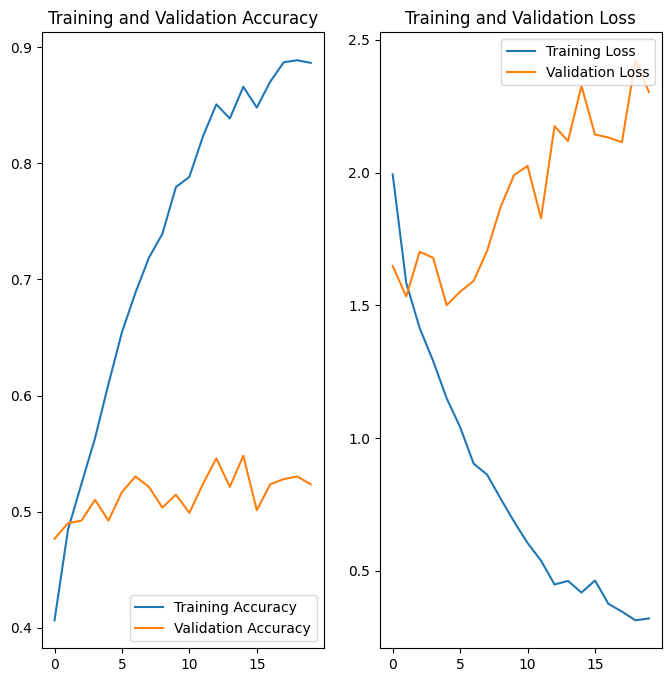

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observation** -<br>
The accuracy now went up to 0.88 but the validation accuracy is less 0.49<br>
Overfitting generally happens when there is less training data. Data Augumentation can help in generating more training data.<br><br>



##5. Data augmentation strategy to resolve overfitting
We will `RandomFlip`, Keras preprocessing layer for data augumentation:<br>

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3))
  ]
)

Visualize the augumented data

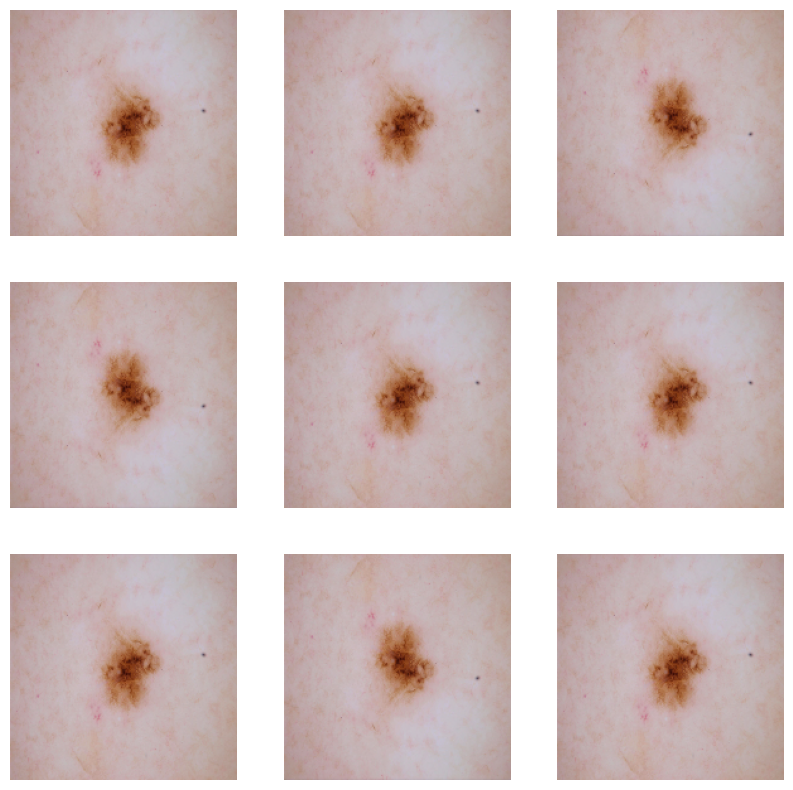

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

##6. Model Building & training on the augmented data

Creating the model

In [21]:
num_classes = len(class_names)
# model
model = Sequential([
    data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

#### Compile the model

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_3 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 88, 88, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 88, 88, 64)        0         
                                                      

#### Train the model

In [23]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 99ms/step - loss: 5.2466 - accuracy: 0.1646 - val_loss: 2.0988 - val_accuracy: 0.2103
Epoch 2/20
56/56 [==============================] - 5s 97ms/step - loss: 2.1303 - accuracy: 0.1953 - val_loss: 2.0591 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 5s 96ms/step - loss: 2.1138 - accuracy: 0.2132 - val_loss: 2.0821 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 5s 95ms/step - loss: 2.1353 - accuracy: 0.1802 - val_loss: 2.1413 - val_accuracy: 0.1521
Epoch 5/20
56/56 [==============================] - 5s 95ms/step - loss: 2.1048 - accuracy: 0.1881 - val_loss: 2.0837 - val_accuracy: 0.2103
Epoch 6/20
56/56 [==============================] - 5s 94ms/step - loss: 2.0780 - accuracy: 0.2076 - val_loss: 2.0302 - val_accuracy: 0.2304
Epoch 7/20
56/56 [==============================] - 5s 96ms/step - loss: 2.0374 - accuracy: 0.2394 - val_loss: 1.9727 - val_accuracy: 0.2864
Epoch 8/20
56

**Visualize the results**

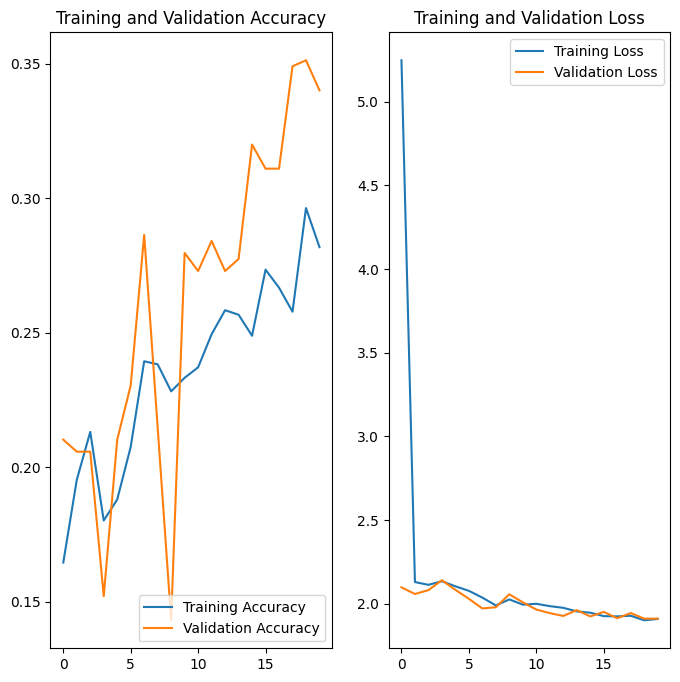

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see that the gap between training and validation accuracy has come down largely. We had to compromise on training accuracy to achieve that, but now this model is less overfitted.

We will try other ways to further improve the model, starting with `Class Imbalance`

##7. Class distribution
Let's see the ditribution of different classes in the training dataset.

In [33]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

Create a dataframe for the classes

In [34]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


Visualize the data

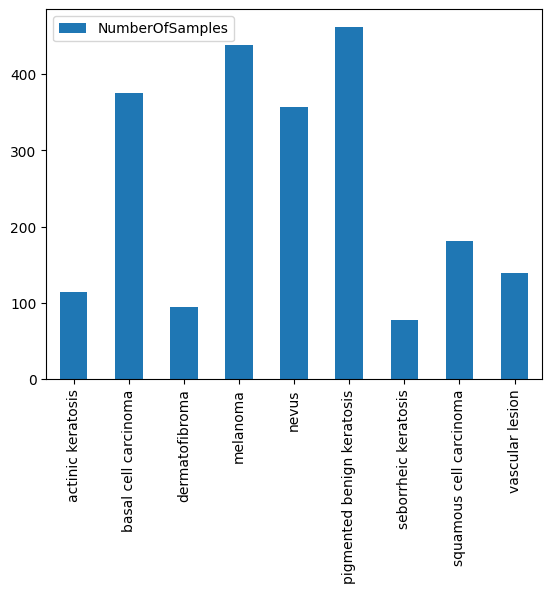

In [35]:
class_df.plot.bar()
plt.show()

##8. Handling class imbalances<br>
We will class imbalances present in the training dataset with `Augmentor` library

To use Augmentor, the following general procedure is followed:



1.   Instantiate a `Pipeline` object pointing to a directory containing initial image data set.
2.   Define a number of operations to perform on this data set using the `Pipeline` object.
3.   Execute these operations by calling the `Pipeline's` `sample()` method.

In [37]:
!pip install Augmentor

Step 1: Create a New Pipeline<br>

In [61]:
path_to_training_dataset="drive/My Drive/Colab Notebooks/CNN_assignment/Train/"
import Augmentor
for i in class_names: #For Each class
    p = Augmentor.Pipeline(path_to_training_dataset + i)
#Step 2: Add Operations to the Pipeline
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#Step 3: Execute and Sample From the Pipeline
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

OSError: ignored

##9. Model Building & training on the rectified class imbalance data

Create train and validation data set from the data in output location

In [27]:
data_dir_train_out = pathlib.Path("drive/My Drive/Colab Notebooks/CNN_assignment/Output/")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_out,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_out,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating the model

In [ ]:
num_classes = len(class_names)
# model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

Compile the Model

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Train the model

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Visualize the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()